Customer Purchase behaviour analysis and Loyalty prediction


In [217]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [218]:
#Reading the data
df=pd.read_excel('Electronic.xlsx')

In [219]:
df.head()

,Age,Items Purchased,Total Spent,Discount (%),Satisfaction Score,Warranty Extension,Gender,Region,Product Category,Payment Method,Revenue,Store Rating,Loyalty Score,Membership Status,Preferred Visit Time
0,56,1,29.226195,47.077380,1.000000,1,Male,South,Accessories,UPI,149.252145,3.660461,3.597133,1.0,Evening
1,69,10,420.142612,7.985739,3.760294,1,Female,South,Accessories,Cash,1485.524222,3.551553,25.764903,1.0,Evening
2,46,4,127.742817,37.225718,1.771240,1,Male,East,Laptop,Credit Card,85.550131,3.922839,7.022399,1.0,Morning
3,32,9,417.722683,8.227732,1.926831,0,Female,East,Tablet,UPI,824.118724,3.860422,7.635412,1.0,Afternoon
4,60,13,608.031366,5.000000,3.902927,0,Female,South,Tablet,UPI,2463.590392,3.812820,29.461119,0.0,Morning


Preprocessing

In [220]:
#Shape of dataframe
df.shape

(5000, 15)

In [221]:
#Concise summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   5000 non-null   int64  
 1   Items Purchased       5000 non-null   int64  
 2   Total Spent           5000 non-null   float64
 3   Discount (%)          5000 non-null   float64
 4   Satisfaction Score    5000 non-null   float64
 5   Warranty Extension    5000 non-null   int64  
 6   Gender                4998 non-null   object 
 7   Region                5000 non-null   object 
 8   Product Category      5000 non-null   object 
 9   Payment Method        4996 non-null   object 
 10  Revenue               5000 non-null   float64
 11  Store Rating          4997 non-null   float64
 12  Loyalty Score         5000 non-null   float64
 13  Membership Status     4994 non-null   float64
 14  Preferred Visit Time  4992 non-null   object 
dtypes: float64(7), int64(

In [222]:
#FInding the number of unique values in each column
for i in df.columns:
    print(i,df[i].nunique())

Age 52
Items Purchased 14
Total Spent 5000
Discount (%) 4417
Satisfaction Score 2787
Warranty Extension 2
Gender 3
Region 4
Product Category 5
Payment Method 5
Revenue 5000
Store Rating 4997
Loyalty Score 4962
Membership Status 2
Preferred Visit Time 3


Observation
1) Columns Items Purchased,Warranty Extension,Gender,Region,Product Category,Payment Method,Membership Status,Preferred Visit TIme are of categorical nature.

In [223]:
#Checking for any duplicate rows
df.duplicated().sum()

0

In [224]:
#Checking for any null values
df.isnull().sum()

Age                     0
Items Purchased         0
Total Spent             0
Discount (%)            0
Satisfaction Score      0
Warranty Extension      0
Gender                  2
Region                  0
Product Category        0
Payment Method          4
Revenue                 0
Store Rating            3
Loyalty Score           0
Membership Status       6
Preferred Visit Time    8
dtype: int64

Observation
1) Missing values observed in columns Gender,Payment Method,Store Rating,Membership Status,Preferred Visit Time.
2) Other than Store Rating ,all othe columns with missing values are of categorical nature and can be imputed with mode.
3) Missing values in Store Rating can be imputed with median.

In [225]:
#Handling missing values
df['Store Rating'].fillna(df['Store Rating'].median(),inplace=True)
from sklearn.impute import SimpleImputer
null_columns = df.columns[df.isnull().any()]
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer=imp_mode.fit(df[null_columns])
df_imp=imputer.transform(df[null_columns])
df_imp=pd.DataFrame(df_imp)
df_imp.columns=['Gender','Payment Method','Membership Status','Preferred Visit Time']
df[null_columns]=df_imp[null_columns]

In [226]:
df.isna().sum()

Age                     0
Items Purchased         0
Total Spent             0
Discount (%)            0
Satisfaction Score      0
Warranty Extension      0
Gender                  0
Region                  0
Product Category        0
Payment Method          0
Revenue                 0
Store Rating            0
Loyalty Score           0
Membership Status       0
Preferred Visit Time    0
dtype: int64

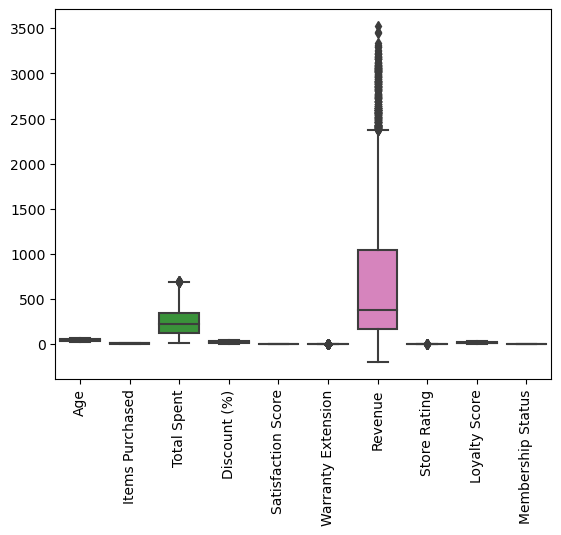

In [227]:
#Checking for outlier using boxplot
sns.boxplot(df)
plt.xticks(rotation=90)
plt.show()

In [228]:
num_columns=['Age','Total Spent','Discount (%)','Satisfaction Score','Revenue','Store Rating','Loyalty Score']
# Calculate IQR for numerical columns
Q1 = df[num_columns].quantile(0.25)
Q3 = df[num_columns].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = ((df[num_columns] < lower_bound) | (df[num_columns] > upper_bound)).sum()
print(outliers)

Age                     0
Total Spent            13
Discount (%)            0
Satisfaction Score      0
Revenue               301
Store Rating           14
Loyalty Score           0
dtype: int64


Observations:
1) Outliers present in columns Total Spent,Revenue and Store Rating
2) Outliers in Total Spent and Store Rating are less in number.
3) Outliers appear to be genuine

Text(0, 0.5, 'Frequency')

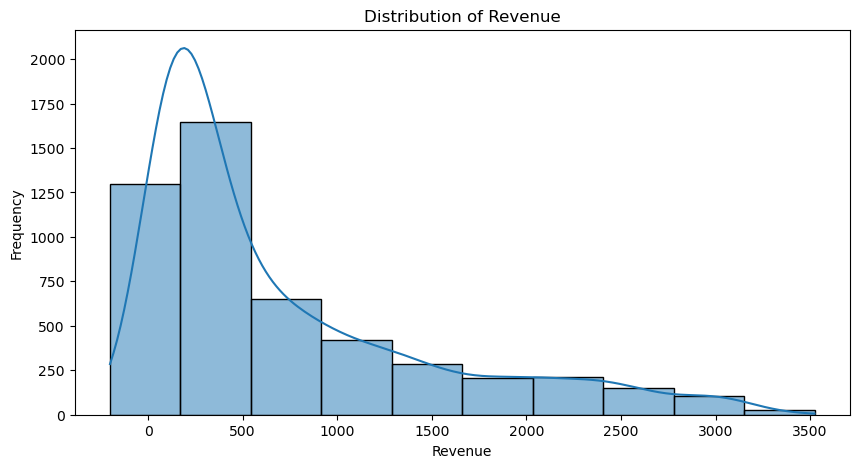

In [229]:
plt.figure(figsize=(10, 5)) 
sns.histplot(df['Revenue'], bins=10, kde=True) 
plt.title('Distribution of Revenue') 
plt.xlabel('Revenue') 
plt.ylabel('Frequency')

Observation:
 Distribution of revenue shows most of the revenue are in lower range.

Text(0, 0.5, 'Frequency')

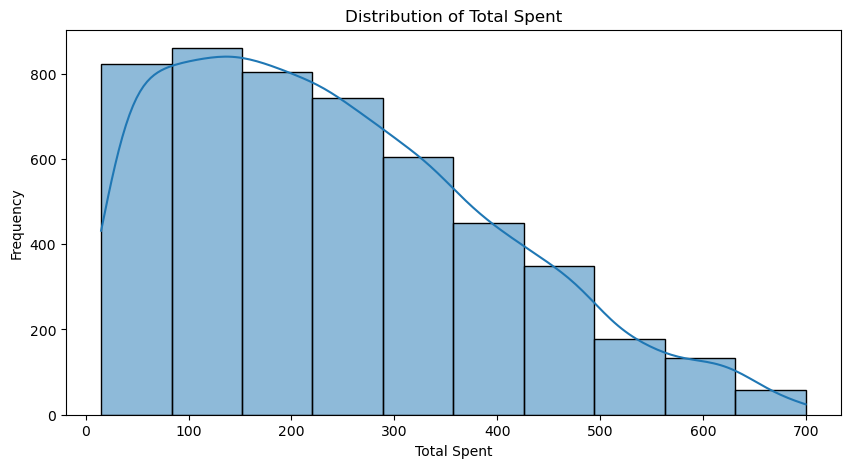

In [230]:
plt.figure(figsize=(10, 5)) 
sns.histplot(df['Total Spent'], bins=10, kde=True) 
plt.title('Distribution of Total Spent') 
plt.xlabel('Total Spent') 
plt.ylabel('Frequency')

Observation:
1) Most of the spending amounts are in lower range with a few in higher range.
2) Majority spending amounts are clustered between 100-200 range.
3) Higher spending values towards the tail end indicates there are a few high spending customers.

In [231]:
outlier_columns=['Total Spent','Revenue','Store Rating']
for i in outlier_columns:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    # # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # # Identify outliers
    df[i] = np.where(df[i] > upper_bound, upper_bound, np.where(df[i] < lower_bound, lower_bound, df[i]))

In [232]:
#Binning on Satisfaction Score and Loyalty scrore for better understanding of data
bins=[1,2,3,4,5]
labels=['Poor','Average','Good','Excellent']
df['SS']=pd.cut(df['Satisfaction Score'],bins=bins,labels=labels,include_lowest=True,right=True)
bins_1=[0,10,20,30,40]
labels_1=[1,2,3,4]
df['Loyal']=pd.cut(df['Loyalty Score'],bins=bins_1,labels=labels_1,include_lowest=True,right=True)

In [233]:
df['SS'].value_counts(normalize=True)

Poor         0.4444
Excellent    0.2638
Average      0.1540
Good         0.1378
Name: SS, dtype: float64

In [234]:
df['Loyal'].value_counts(normalize=True)

1    0.3532
2    0.3108
3    0.2600
4    0.0760
Name: Loyal, dtype: float64

In [235]:
numeric_cols = df.select_dtypes(include=['number'])
#Items purchased ,Warranty extension,Store rating can be considered as categorical in nature.Hence we can drop them for finding correlation.
numeric_cols.drop(['Items Purchased','Warranty Extension','Store Rating'],axis=1,inplace=True)
object_cols = df.select_dtypes(include=['object']) 

In [236]:
numeric_cols.describe()

,Age,Total Spent,Discount (%),Satisfaction Score,Revenue,Loyalty Score
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,43.584600,243.707342,26.622330,2.650108,695.021226,15.638275
std,14.919094,154.907175,13.586725,1.533394,716.766601,9.144742
min,18.000000,15.105730,5.000000,1.000000,-201.427094,0.000000
25%,31.000000,119.130074,15.382663,1.000000,164.697614,7.944790
50%,43.000000,221.514206,27.848579,2.338884,380.548500,13.969791
75%,56.000000,346.173367,38.086993,4.129317,1047.426498,23.521601
max,69.000000,686.738308,48.489427,5.000000,2371.519824,39.235392


In [237]:
object_cols.describe(include=['object'])

,Gender,Region,Product Category,Payment Method,Membership Status,Preferred Visit Time
count,5000,5000,5000,5000,5000.0,5000
unique,3,4,5,5,2.0,3
top,Male,South,Accessories,Net Banking,0.0,Morning
freq,2448,1310,1015,1042,3460.0,1680


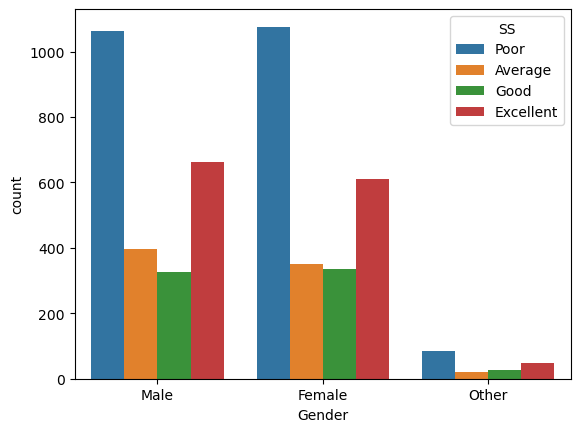

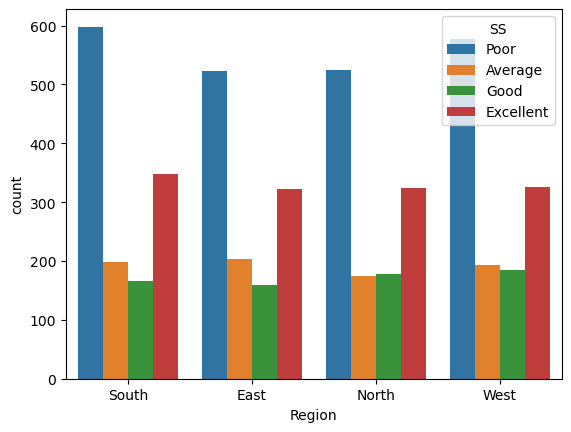

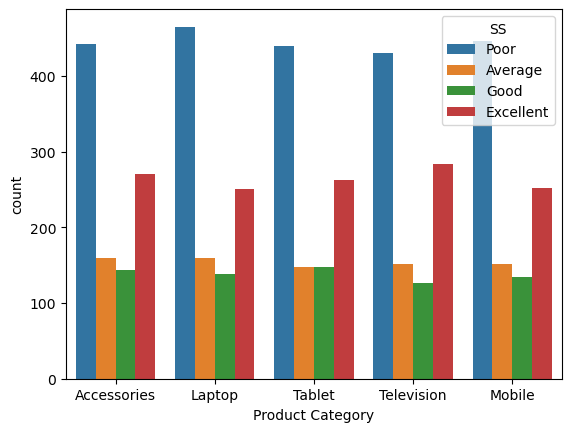

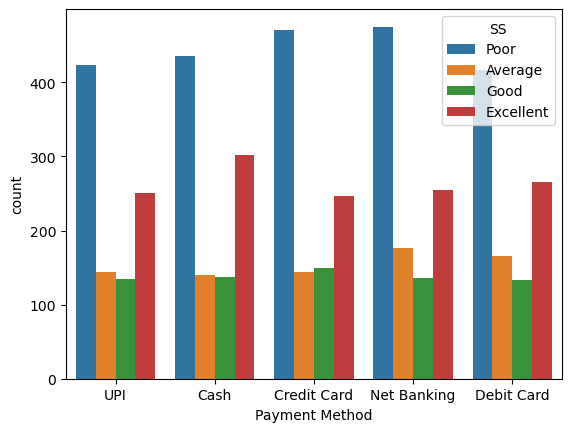

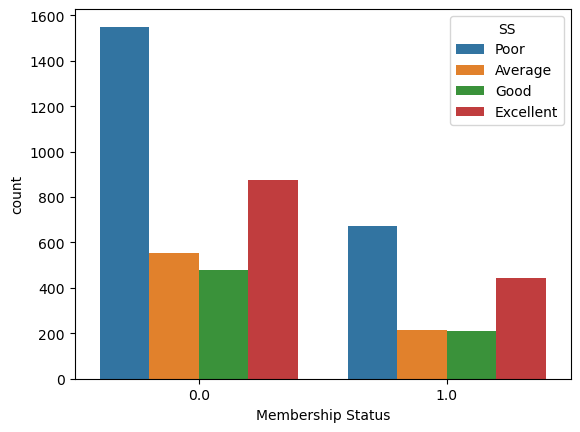

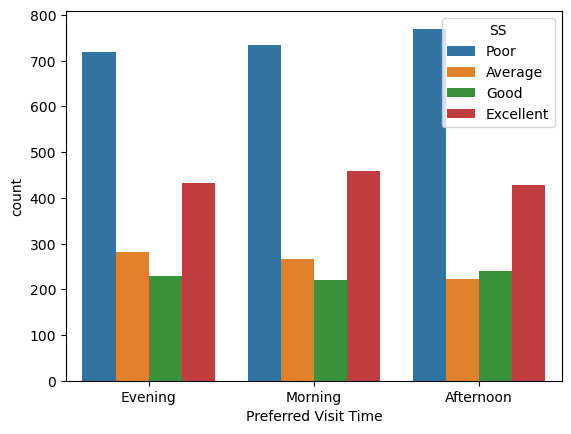

In [238]:
#Univariate analysis 
for i in object_cols:
    sns.countplot(data=df,x=i,hue='SS')
    plt.show()

<Axes: xlabel='Loyalty Score_r', ylabel='Satisfaction Score_r'>

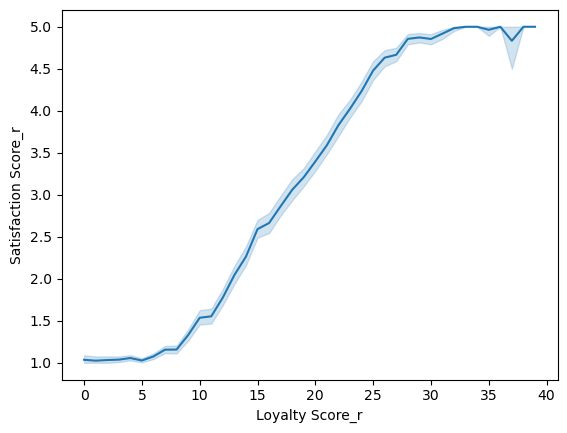

In [239]:
df['Satisfaction Score_r']=df['Satisfaction Score'].round()
df['Loyalty Score_r']=df['Loyalty Score'].round()
sns.lineplot(data=df,y='Satisfaction Score_r',x='Loyalty Score_r',)

Observation:
1) Plot suggest a positive correlation between Loyalty Score and Satisfaction Score
2) For loyalty score between 0 and 10,Satisfaction Score is stable around 1
3) After that a noticable upward trend in Satisfaction Score
4) There is a slight dip in Satisfaction Score around Loyalty Score of 37.This may be due to outliers 
5) Business may focus on customer with medium to high loyalty score to increase Satisfaction Score

In [240]:
df.drop(['Satisfaction Score_r','Loyalty Score_r'],inplace=True,axis=1)


In [241]:
numeric_cols.corr()

,Age,Total Spent,Discount (%),Satisfaction Score,Revenue,Loyalty Score
Age,1.000000,-0.003176,0.000439,0.000331,-0.004934,0.009317
Total Spent,-0.003176,1.000000,-0.979130,0.597263,0.880517,0.669732
Discount (%),0.000439,-0.979130,1.000000,-0.589436,-0.847857,-0.659179
Satisfaction Score,0.000331,0.597263,-0.589436,1.000000,0.803601,0.935086
Revenue,-0.004934,0.880517,-0.847857,0.803601,1.000000,0.822512
Loyalty Score,0.009317,0.669732,-0.659179,0.935086,0.822512,1.000000


Observations:
1) Feature Age has very less correlation with any other variable and do not have any significant impact on any other variable.
2) Total Spent has strong negative correlation with Discount and high positive correlation with Revenue and loyalty score.
3) Discount have strong negative correlation with Total Spent and Revenue suggesting customers who require large discounts may not be the loyal or revenue generating customers.
4) Satisfaction score is highly positve correlated with Revenue and loyalty score.
5) Revenue has high positve correlation with Total spent,Satisfaction score and loyalty score

Text(0, 0.5, 'Loyalty score')

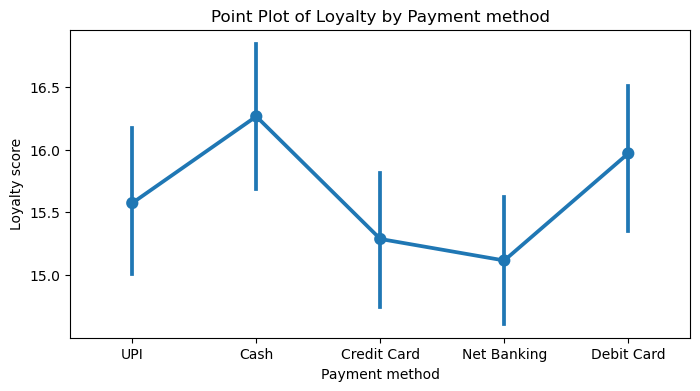

In [242]:
plt.figure(figsize=(8, 4)) 
sns.pointplot(x='Payment Method', y='Loyalty Score', data=df)
plt.title('Point Plot of Loyalty by Payment method') 
plt.xlabel('Payment method') 
plt.ylabel('Loyalty score')

Observation:
1) Customers who use cash payment and UPI and debit card is having high loyalty score around 16
2) Customers using credit card and net banking having less loyalty score.
3) Business can focus on giving special offers to customers using net banking and creditcards.

Text(0, 0.5, 'Loyalty score')

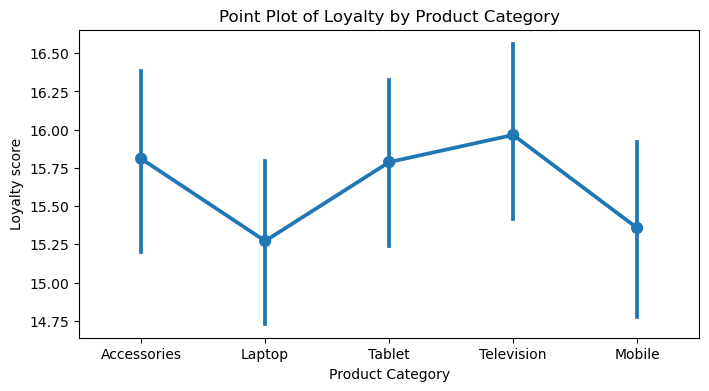

In [243]:
plt.figure(figsize=(8, 4)) 
sns.pointplot(x='Product Category', y='Loyalty Score', data=df)
plt.title('Point Plot of Loyalty by Product Category') 
plt.xlabel('Product Category') 
plt.ylabel('Loyalty score')

Text(0, 0.5, 'Loyalty score')

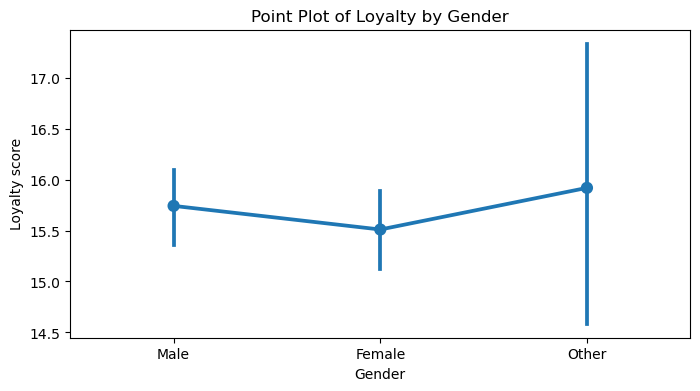

In [244]:
plt.figure(figsize=(8, 4)) 
sns.pointplot(x='Gender', y='Loyalty Score', data=df)
plt.title('Point Plot of Loyalty by Gender') 
plt.xlabel('Gender') 
plt.ylabel('Loyalty score')

Observation:
Loyalty score are relatively high and consistent for male and female.Other category shows slightly higher loyalty but with high variability.Not much difference in loyalty score based on gender.

Text(0, 0.5, 'Loyalty score')

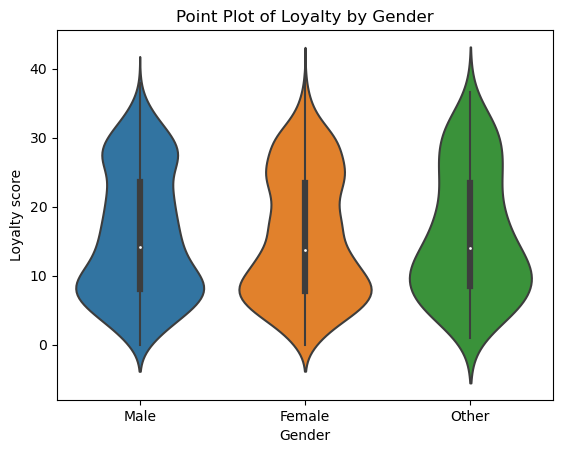

In [245]:
sns.violinplot(x='Gender', y='Loyalty Score', data=df)
plt.title('Point Plot of Loyalty by Gender') 
plt.xlabel('Gender') 
plt.ylabel('Loyalty score')

Text(0, 0.5, 'Loyalty score')

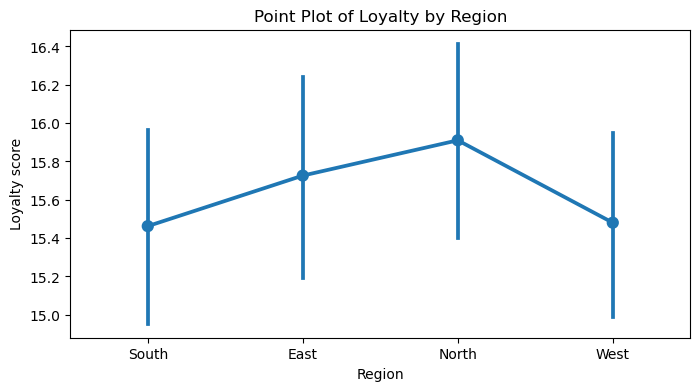

In [246]:
plt.figure(figsize=(8, 4)) 
sns.pointplot(x='Region', y='Loyalty Score', data=df)
plt.title('Point Plot of Loyalty by Region') 
plt.xlabel('Region') 
plt.ylabel('Loyalty score')

Observation:
North region shows more loyalty score .But Region do not have  much impact on loyalty score

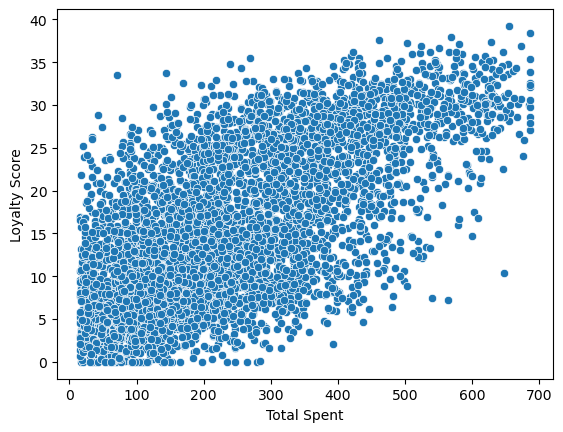

In [247]:
sns.scatterplot(x='Total Spent',y='Loyalty Score',data=df)
plt.show()

Observation
1) As the value of Total Spent increase,Loyalty score also increase showing a positive correlation.
2) There is a noticable spread in data points indicating varaibility in relaionship.
3) Though there is a general trend,individual data point can deviate.It indicates other factors also influence loyalty score

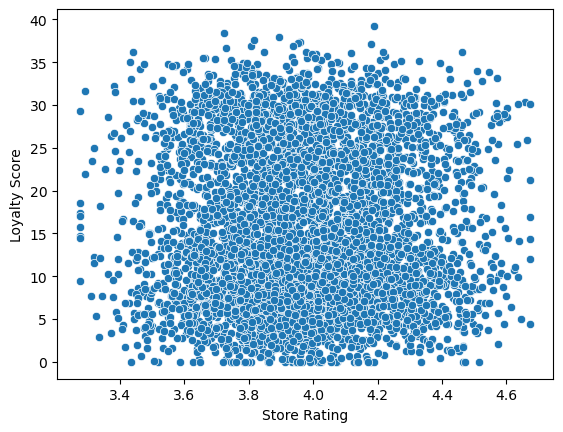

In [248]:
sns.scatterplot(x='Store Rating',y='Loyalty Score',data=df)
plt.show()

Observation:
This scatter plot suggests there is no strong correlation between Store rating and loyalty score.Lack of clear pattern shows loyalty score is distributed across all store ratings without a consistent relationship.

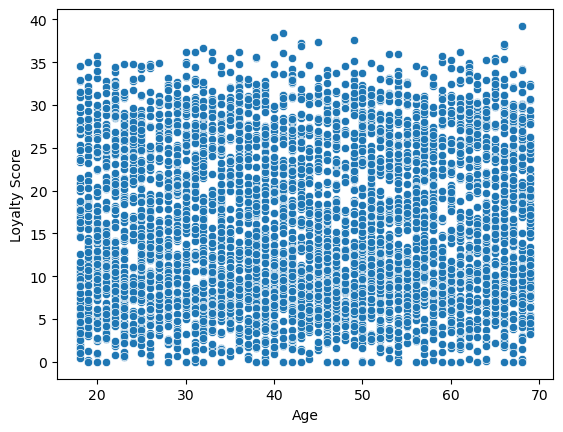

In [249]:
sns.scatterplot(x='Age',y='Loyalty Score',data=df)
plt.show()

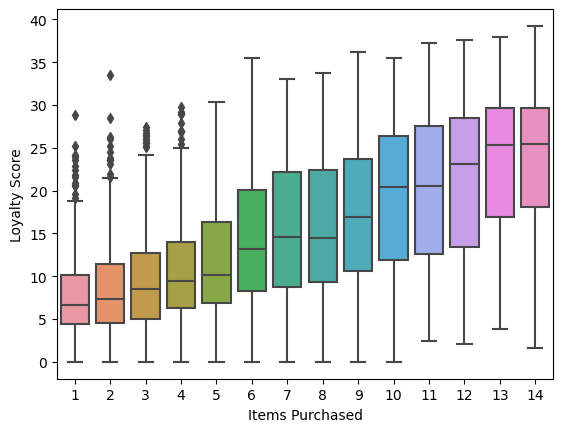

In [250]:
sns.boxplot(x='Items Purchased',y='Loyalty Score',data=df)
plt.show()

Observation:
1) As the number of othems purchased increase,loyalty score also tends to increase showing a positive correlation.
2) For lower number of items purchased,loyalty score is widely spread ranging from 0 to 35.
3) As the number of items purchased is more than 4,loyalty score is clusterd around high loyalty score.
4) This suggest customers who buy more tend to have good loyalty score.
5) Business must focus on startegies that encourages customers to purchase more items.



In [251]:
df.corr()['Discount (%)']

C:\Users\Sunitha\AppData\Local\Temp\ipykernel_17916\1422112945.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['Discount (%)']


Age                   0.000439
Items Purchased      -0.853837
Total Spent          -0.979130
Discount (%)          1.000000
Satisfaction Score   -0.589436
Warranty Extension   -0.086038
Revenue              -0.847857
Store Rating         -0.013940
Loyalty Score        -0.659179
Name: Discount (%), dtype: float64

Observation:
1) High negative  correlation between items purchased and discount implies discount are being offered to fewer items or customers are not buying in bulk even after offering discount.
2) Higher discounts are strongly associated with lower total spending and revenue suggesting discounts not effectively driving overall sales.
3) Noticable negative impact of higher discounts on Satsfaction Score and Loyalty Score,indicating giving large discounts is not the best strategy.
4) Customer may be considering high discount items as low in quality or less desirable item.
5) Discounts have little impact on features Warranty extension,Store rating and membership status.

<Axes: xlabel='Product Category', ylabel='Discount (%)'>

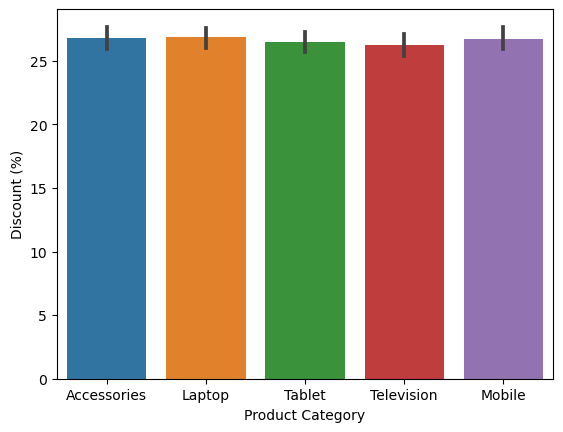

In [252]:
sns.barplot(x='Product Category',y='Discount (%)',data=df)

Observation 
All product categories are receiving a uniform discount percentage

<Axes: xlabel='Warranty Extension', ylabel='count'>

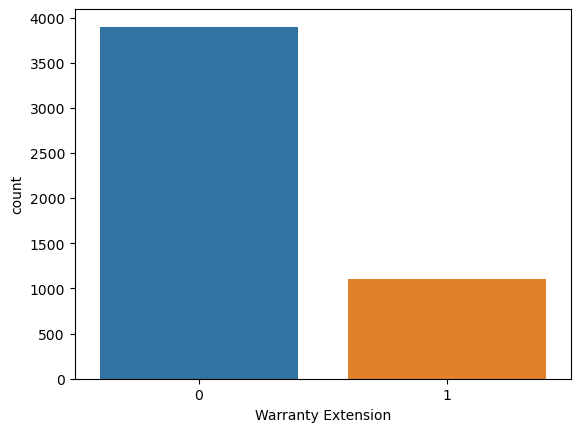

In [253]:
sns.countplot(data=df,x='Warranty Extension')

Text(0, 0.5, 'Loyalty score')

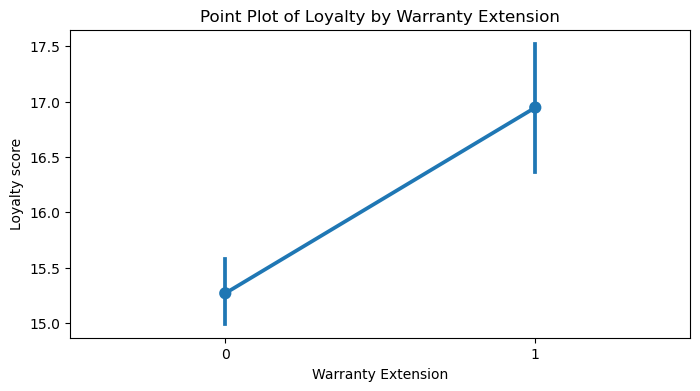

In [254]:
plt.figure(figsize=(8, 4)) 
sns.pointplot(x='Warranty Extension', y='Loyalty Score', data=df)
plt.title('Point Plot of Loyalty by Warranty Extension') 
plt.xlabel('Warranty Extension') 
plt.ylabel('Loyalty score')

Observation:
1) Customers with warranty extension shows higher loyalty score

Text(0, 0.5, 'Loyalty score')

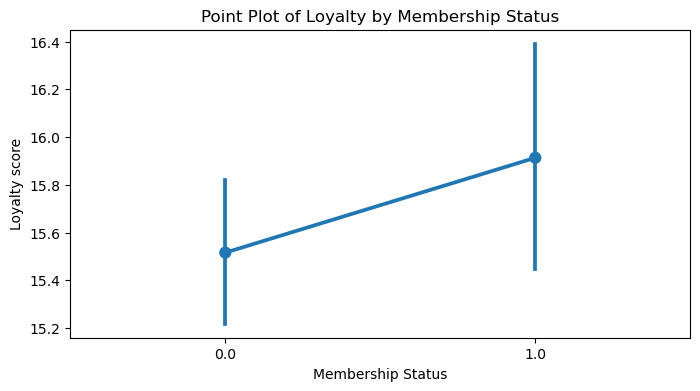

In [255]:
plt.figure(figsize=(8, 4)) 
sns.pointplot(x='Membership Status', y='Loyalty Score', data=df)
plt.title('Point Plot of Loyalty by Membership Status') 
plt.xlabel('Membership Status') 
plt.ylabel('Loyalty score')

Observation:
1) Members have slightly higher loyalty score than non members
2) Extending membership can increase loyalty score

<Axes: xlabel='Membership Status', ylabel='count'>

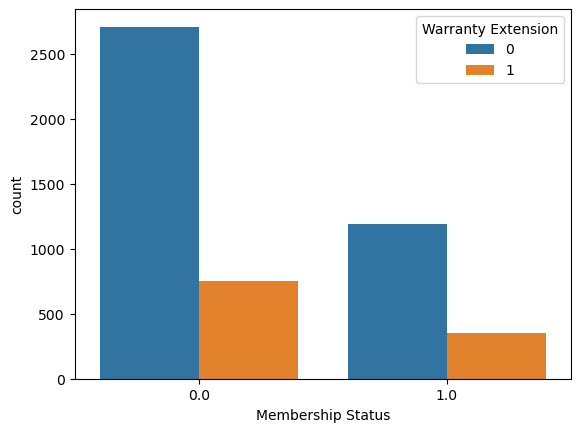

In [256]:
sns.countplot(x='Membership Status',hue='Warranty Extension',data=df)

In [257]:
from scipy.stats import chi2_contingency
# Create a contingency table 
contingency_table = pd.crosstab(df['Membership Status'], df['Warranty Extension']) 
# Perform the Chi-Square test 
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table) 
print(f'Chi-Square Statistic: {chi2_stat}, p-value: {p_val}')

Chi-Square Statistic: 0.5553355016830506, p-value: 0.45614576901547277


As P value is more than 0.05,accept null hypothesis.That is there is no significant association between Membership Staus and Warranty Extension.

Text(0, 0.5, 'Loyalty score')

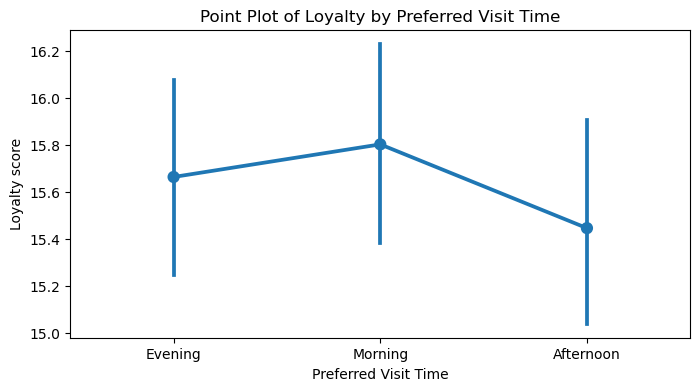

In [258]:
plt.figure(figsize=(8, 4)) 
sns.pointplot(x='Preferred Visit Time', y='Loyalty Score', data=df)
plt.title('Point Plot of Loyalty by Preferred Visit Time') 
plt.xlabel('Preferred Visit Time') 
plt.ylabel('Loyalty score')

Observation:
    Morning visits have relatively higher customer loyalty score with slight variabilty while afternoon visit shows slightly low loyalty scores.But not much wide difference.

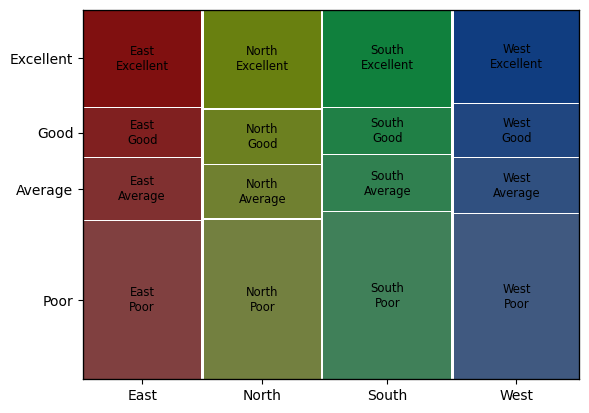

In [259]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df, ['Region', 'SS']) 
plt.show()

Observation:
1) Poor satisfaction is dominant across all regions
2) There is a considerable amount of highly satisfied customers also.
3) The average and Good categories are less in number across all regions

<Axes: xlabel='Preferred Visit Time', ylabel='count'>

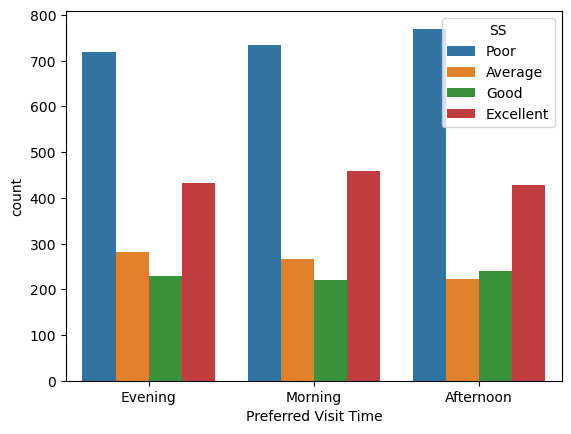

In [260]:
#plt.bar(df['Preferred Visit Time'],counts,color=['blue', 'orange', 'green'])
sns.countplot(data=df,x='Preferred Visit Time',hue='SS')

In [261]:
contingency_table=pd.crosstab(df['Gender'],df['Product Category'])
contingency_table

Product Category,Accessories,Laptop,Mobile,Tablet,Television
Gender,,,,,
Female,471,495,453,474,478
Male,510,481,493,485,479
Other,34,37,38,38,34


In [262]:
contingency_table=pd.crosstab(df['Region'],df['Product Category'])
contingency_table

Product Category,Accessories,Laptop,Mobile,Tablet,Television
Region,,,,,
East,254,221,233,269,231
North,230,256,234,217,264
South,269,258,292,237,254
West,262,278,225,274,242


In [263]:
contingency_table=pd.crosstab(df['Region'],df['SS'])
contingency_table

SS,Poor,Average,Good,Excellent
Region,,,,
East,523,203,160,322
North,524,175,178,324
South,598,199,166,347
West,577,193,185,326


In [264]:
print(df['Membership Status'].value_counts(normalize=True))
contingency_table=pd.crosstab(df['SS'],df['Membership Status'])
contingency_table

0.0    0.692
1.0    0.308
Name: Membership Status, dtype: float64


Membership Status,0.0,1.0
SS,,
Poor,1550,672
Average,554,216
Good,479,210
Excellent,877,442


C:\Users\Sunitha\AppData\Local\Temp\ipykernel_17916\2537347174.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Satisfaction Score'])


<Axes: xlabel='Satisfaction Score', ylabel='Density'>

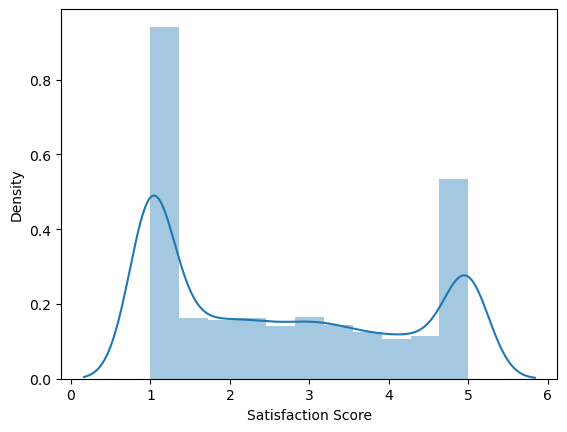

In [265]:
sns.distplot(df['Satisfaction Score'])

C:\Users\Sunitha\AppData\Local\Temp\ipykernel_17916\3706292073.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Loyalty Score'])


<Axes: xlabel='Loyalty Score', ylabel='Density'>

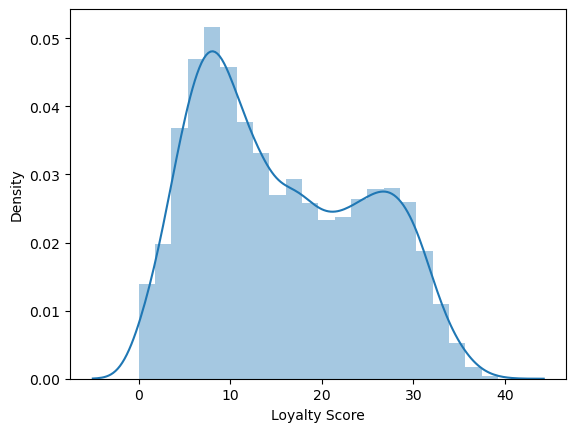

In [266]:
sns.distplot(df['Loyalty Score'])

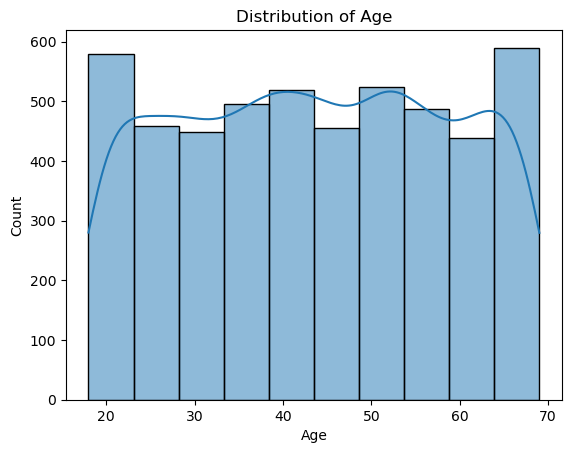

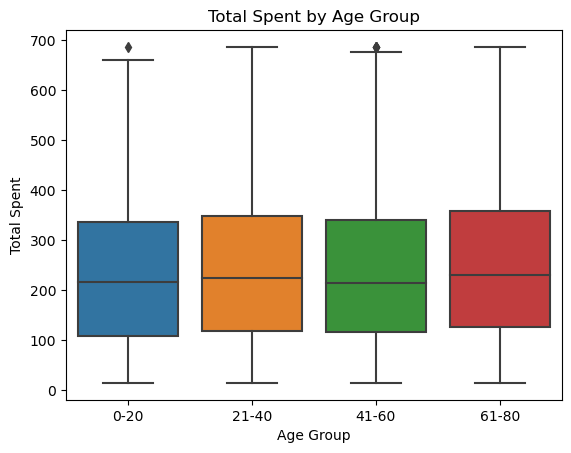

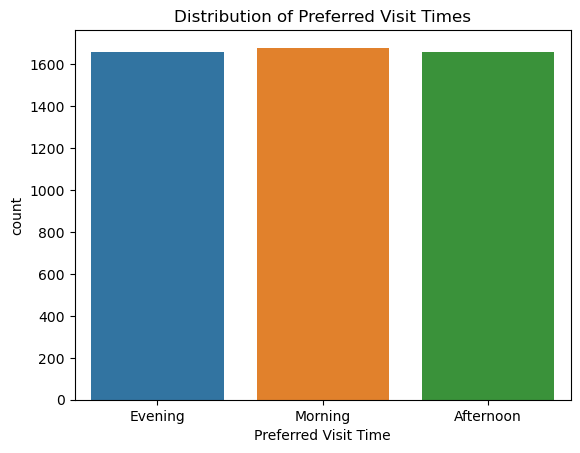

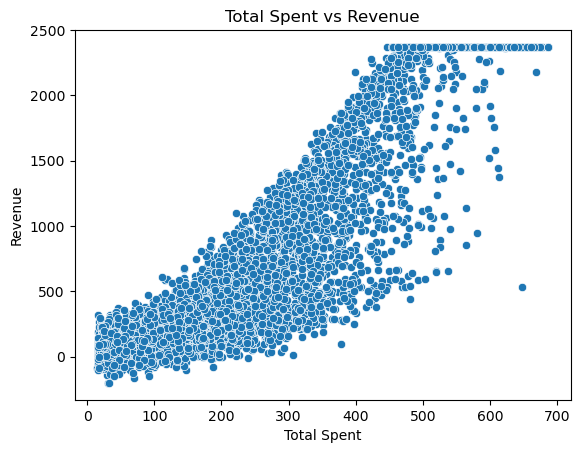

C:\Users\Sunitha\AppData\Local\Temp\ipykernel_17916\3607137542.py:27: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


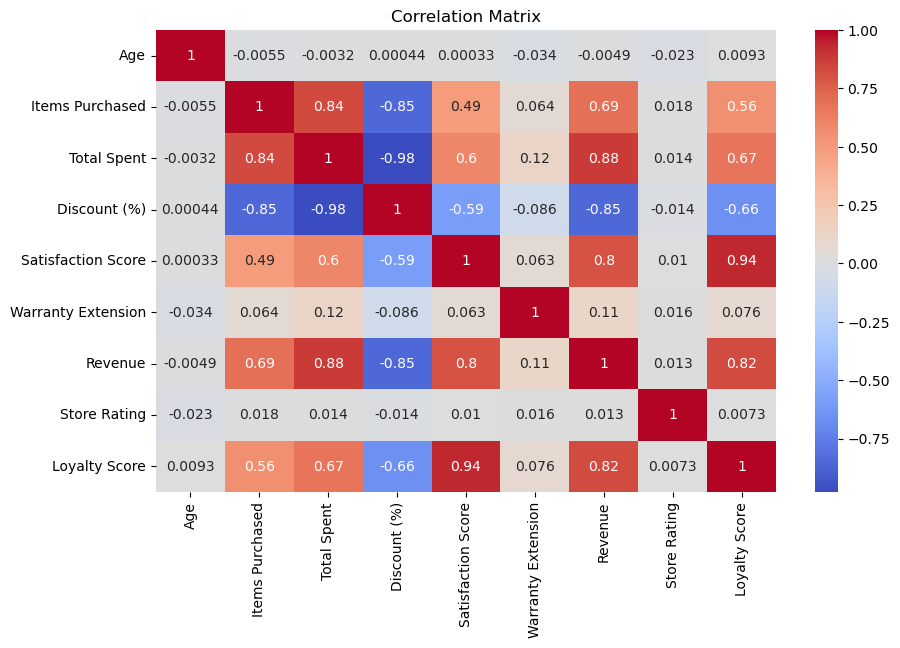

In [267]:
# Binning Age 
bins = [0, 20, 40, 60, 80] 
labels = ['0-20', '21-40', '41-60', '61-80'] 
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels)
# Histogram
sns.histplot(df['Age'], bins=10, kde=True)
plt.title('Distribution of Age')
plt.show()

# Box plot
sns.boxplot(x='Age Group', y='Total Spent', data=df)
plt.title('Total Spent by Age Group')
plt.show()

# Bar chart for categorical variables
sns.countplot(x='Preferred Visit Time', data=df)
plt.title('Distribution of Preferred Visit Times')
plt.show()

# Scatter plot
sns.scatterplot(x='Total Spent', y='Revenue', data=df)
plt.title('Total Spent vs Revenue')
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [268]:
grouped =df.groupby(['Product Category','Region']).agg({'Total Spent':'mean','Items Purchased':'mean','Revenue':'mean','Satisfaction Score':'mean' }).reset_index()
grouped

,Product Category,Region,Total Spent,Items Purchased,Revenue,Satisfaction Score
0,Accessories,East,247.517730,7.751969,739.586823,2.749485
1,Accessories,North,253.582320,7.934783,724.441622,2.684178
2,Accessories,South,234.754604,7.464684,668.449285,2.637187
3,Accessories,West,237.769868,7.729008,656.880092,2.602796
4,Laptop,East,238.608351,7.411765,659.043016,2.715963
5,Laptop,North,247.760708,7.503906,709.526810,2.665961
6,Laptop,South,232.529518,7.449612,626.478474,2.462558
7,Laptop,West,240.163434,7.356115,661.689324,2.572268
8,Mobile,East,243.301775,7.193133,678.996609,2.619838
9,Mobile,North,240.251166,7.333333,702.783717,2.677596


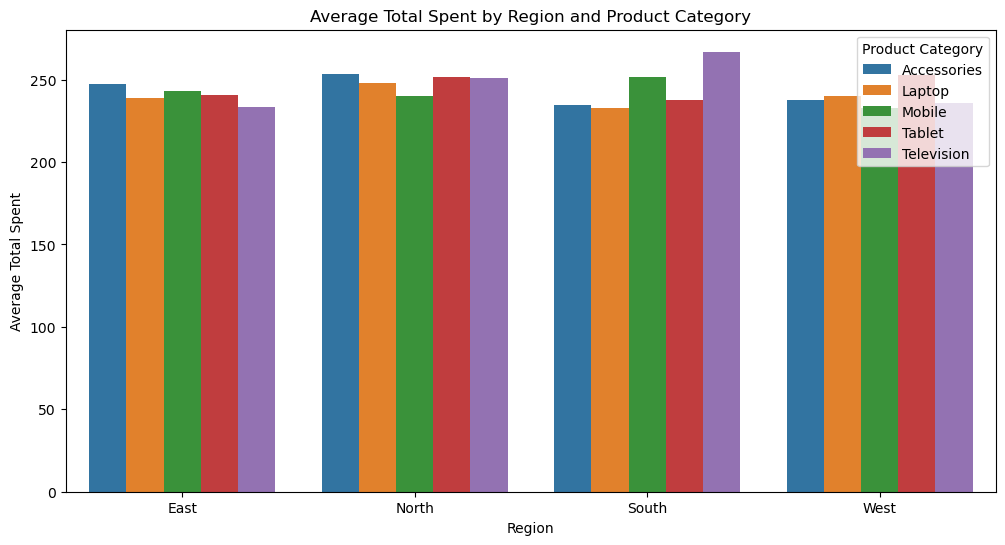

In [269]:
plt.figure(figsize=(12, 6)) 
sns.barplot(data=grouped,x='Region',y='Total Spent',hue='Product Category')
plt.title('Average Total Spent by Region and Product Category') 
plt.ylabel('Average Total Spent') 
plt.xlabel('Region')
plt.legend(title='Product Category')
plt.show()

Summary of analysis:
1) Since Discount and Total Spent are correlated and Total spent is more correlated with Loyalty score,Discount can be dropped.
2) Features Age,Gender,Region do not have much impact on Loyalty score

In [270]:
#Discount and Total spent are correlated,so discount can be removed from model
df_new=df.drop('Discount (%)',axis=1)

In [271]:

df_new.drop(['Age','Gender','Region','SS','Loyal','Age Group'],axis=1,inplace=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Items Purchased       5000 non-null   int64  
 1   Total Spent           5000 non-null   float64
 2   Satisfaction Score    5000 non-null   float64
 3   Warranty Extension    5000 non-null   int64  
 4   Product Category      5000 non-null   object 
 5   Payment Method        5000 non-null   object 
 6   Revenue               5000 non-null   float64
 7   Store Rating          5000 non-null   float64
 8   Loyalty Score         5000 non-null   float64
 9   Membership Status     5000 non-null   object 
 10  Preferred Visit Time  5000 non-null   object 
dtypes: float64(5), int64(2), object(4)
memory usage: 429.8+ KB


In [272]:
df_new['Membership Status']=df_new['Membership Status'].astype('int64')

In [273]:
#Encoding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
# Fit and transform the categorical data 
encoded_data = encoder.fit_transform(df_new[['Product Category','Payment Method','Preferred Visit Time']])
# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Product Category','Payment Method','Preferred Visit Time']))
# Concatenate with the original DataFrame 
df_encoded = pd.concat([df_new, encoded_df], axis=1).drop(columns=['Product Category','Payment Method','Preferred Visit Time']) 

C:\Users\Sunitha\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [274]:
# Separate features and target variable 
X = df_encoded.drop('Loyalty Score',axis=1)
y = df_encoded['Loyalty Score']

In [275]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [276]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 


In [277]:
# Feature selection using SelectKBest
from sklearn.feature_selection import SelectKBest, mutual_info_regression
select_k_best = SelectKBest(mutual_info_regression, k=6)
X_new = select_k_best.fit_transform(X_train_scaled, y_train)
selected_features = X.columns[select_k_best.get_support()]
print("Selected features using SelectKBest (mutual_info_regression):", selected_features)

Selected features using SelectKBest (mutual_info_regression): Index(['Items Purchased', 'Total Spent', 'Satisfaction Score', 'Revenue',
       'Membership Status', 'Product Category_Television'],
      dtype='object')


In [278]:
#Splitting the data based on selected features
X=X[['Items Purchased','Total Spent','Satisfaction Score','Revenue','Membership Status','Product Category_Television']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [279]:
#Model building using Linear Regression
from sklearn.linear_model import LinearRegression
# Initialize the model 
model = LinearRegression()
# Train the model 
model.fit(X_train, y_train)

LinearRegression()

In [280]:
#Evaluation of model
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
# Predict on the test set
y_pred = model.predict(X_test)
# Evaluate the model 
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
mae = mean_absolute_error(y_test, y_pred) 
print("Mean Absolute Error (MAE):", mae)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
r2 = r2_score(y_test,y_pred)
print("R2 score:", r2)

Mean Squared Error: 8.542881882904497
Mean Absolute Error (MAE): 2.3541590317638312
Root Mean Squared Error (RMSE): 2.922820877663306
R2 score: 0.8944009010213835


In [281]:
#Model building using RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Initialize the model 
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the model 
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [282]:
#Evaluation of model
# Predict on the test set
y_pred = rf.predict(X_test)
# Evaluate the model 
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
mae = mean_absolute_error(y_test, y_pred) 
print("Mean Absolute Error (MAE):", mae)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
r2 = r2_score(y_test,y_pred)
print("R2 score:", r2)

Mean Squared Error: 9.868193212840627
Mean Absolute Error (MAE): 2.5039511964235044
Root Mean Squared Error (RMSE): 3.1413680479753765
R2 score: 0.8780186445152424


In [283]:
from sklearn.linear_model import Lasso 
# Initialize the model with a regularization parameter 
ls = Lasso(alpha=0.1)
# Train the model 
ls.fit(X_train, y_train)

Lasso(alpha=0.1)

In [284]:
#Evaluation of model
# Predict on the test set
y_pred = ls.predict(X_test)
# Evaluate the model 
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
mae = mean_absolute_error(y_test, y_pred) 
print("Mean Absolute Error (MAE):", mae)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
r2 = r2_score(y_test,y_pred)
print("R2 score:", r2)

Mean Squared Error: 8.503187225188169
Mean Absolute Error (MAE): 2.3501539489272067
Root Mean Squared Error (RMSE): 2.916022500802792
R2 score: 0.8948915691760605


In [285]:
from sklearn.linear_model import Ridge 
# Initialize the model with a regularization parameter 
ri = Ridge(alpha=1.0)
#Train the model
ri.fit(X_train,y_train)

Ridge()

In [286]:
#Evaluation of model
# Predict on the test set
y_pred = ri.predict(X_test)
# Evaluate the model 
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
mae = mean_absolute_error(y_test, y_pred) 
print("Mean Absolute Error (MAE):", mae)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
r2 = r2_score(y_test,y_pred)
print("R2 score:", r2)

Mean Squared Error: 8.542023405805569
Mean Absolute Error (MAE): 2.354061039242325
Root Mean Squared Error (RMSE): 2.922674016342837
R2 score: 0.8944115127106685


Summary of model evaluation

1) LinearRegressor 

  Mean Squared Error: 8.54
  Mean Absolute Error (MAE): 2.35
  Root Mean Squared Error (RMSE): 2.92
  R2 score: 0.89

2) RandomForestRegressor

  Mean Squared Error: 9.87
  Mean Absolute Error (MAE): 2.50
  Root Mean Squared Error (RMSE): 3.14
  R2 score: 0.88

3) Lasso

  Mean Squared Error: 8.50
  Mean Absolute Error (MAE): 2.35
  Root Mean Squared Error (RMSE): 2.92
  R2 score: 0.89

4) Ridge

  Mean Squared Error: 8.54
  Mean Absolute Error (MAE): 2.35
  Root Mean Squared Error (RMSE): 2.92
  R2 score: 0.89

